In [1]:
import unittest
import scanpy as sc

import encoders
import decoders
import core
import latentspace
import training
import loader
import math
import anndata

import torch

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In /home/mahogny/miniconda3_38/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mahogny/miniconda3_38/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mahogny/miniconda3_38/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/mahogny/miniconda3_38/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mahogny/miniconda3_38/lib/pytho

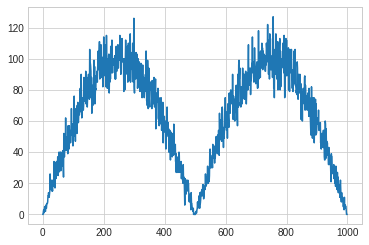

In [2]:
if False:
    ### Real data
    adata = sc.read("data/small_rna.h5ad")
else:
    ### Create artificial data to fit
    num_cell = 1000

    gene1 = [np.random.poisson(int(abs(100*math.sin(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene2 = [np.random.poisson(int(abs(100*math.cos(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene3 = [np.random.poisson(int(abs(100*math.sin(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene4 = [np.random.poisson(int(abs(100*math.cos(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]

    X=[gene1,gene2,gene3,gene4]
    adata=anndata.AnnData(np.array(X).T)

    plt.plot(gene1)

CUDA is available: False
Chose device: 
------------------------ sizes of variables ---------------------
{'X': 4, 'X_sf': 3, 'enc_rna': 10, 'enc_sf': 2, 'sf_rna': 1, 'z': 5, 'rnaseq_count': 4}
---------------------- where variables are used as inputs -------
[('X', ['DVAEencoderFC', 'DVAEencoderFC']), ('enc_sf', ['DVAElatentspaceSizeFactor']), ('X_sf', ['DVAElatentspaceSizeFactor']), ('enc_rna', ['DVAElatentspaceLinear']), ('z', ['DVAEdecoderRnaseq'])]
---------------------- where variables are outputs --------------
[('X', 'DVAEloaderCounts'), ('X_sf', 'DVAEloaderCounts'), ('enc_rna', 'DVAEencoderFC'), ('enc_sf', 'DVAEencoderFC'), ('sf_rna', 'DVAElatentspaceSizeFactor'), ('z', 'DVAElatentspaceLinear'), ('rnaseq_count', 'DVAEdecoderRnaseq')]
-----------------------------------------------------------------
====== num params 2656
training DVAEtrainingBasic epoch 0 loss 2035562.25, in parts {'kl': 873517.6796875, 'reconstruction': 1162044.7598266602}
training DVAEtrainingBasic epoch 1 l

training DVAEtrainingBasic epoch 67 loss 104985.421875, in parts {'kl': 103538.8603515625, 'reconstruction': 1446.5712280273438}
training DVAEtrainingBasic epoch 68 loss 138127.78125, in parts {'kl': 136684.29296875, 'reconstruction': 1443.5026245117188}
training DVAEtrainingBasic epoch 69 loss 132340.359375, in parts {'kl': 130809.537109375, 'reconstruction': 1530.8255767822266}
training DVAEtrainingBasic epoch 70 loss 122365.4609375, in parts {'kl': 120945.669921875, 'reconstruction': 1419.7952423095703}
training DVAEtrainingBasic epoch 71 loss 121568.0234375, in parts {'kl': 120220.3662109375, 'reconstruction': 1347.6575546264648}
training DVAEtrainingBasic epoch 72 loss 122534.4765625, in parts {'kl': 121018.1923828125, 'reconstruction': 1516.2812957763672}
training DVAEtrainingBasic epoch 73 loss 131126.859375, in parts {'kl': 129649.0419921875, 'reconstruction': 1477.8137664794922}
training DVAEtrainingBasic epoch 74 loss 127378.921875, in parts {'kl': 125877.5859375, 'reconstruc

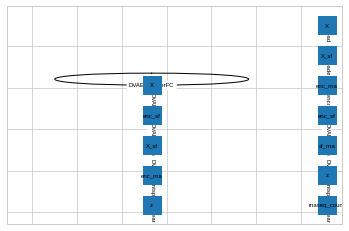

In [3]:
device = training.get_torch_device()

m = core.DVAEmodel(adata)

# rename to input
loader.DVAEloaderCounts(m)

if False:
    the_enc = encoders.DVAEencoderFC(m, inputs="X", output="enc_rna", n_output=4)
    zspace = latentspace.DVAElatentspaceLinear(m, inputs="enc_rna", output="z")
    the_dec = decoders.DVAEdecoderFC(m, inputs="z")
elif False:
    the_enc = encoders.DVAEencoderFC(m, inputs="X", output="enc_rna", n_output=2)
    the_dec = decoders.DVAEdecoderFC(m, inputs="enc_rna")
else:
    # encoder layer
    the_enc = encoders.DVAEencoderFC(m, inputs="X", output="enc_rna", n_output=10)
    the_enc_sf = encoders.DVAEencoderFC(m, inputs="X", output="enc_sf", n_output=2)

    # latent space
    the_l = latentspace.DVAElatentspaceSizeFactor(m, inputs="enc_sf", sf_empirical="X_sf", output="sf_rna")
    zspace = latentspace.DVAElatentspaceLinear(m, inputs="enc_rna", output="z")

    # RNA decoder
    the_dec = decoders.DVAEdecoderRnaseq(
            m,
            inputs="z",
            input_sf="sf_rna",
            gene_likelihood="poisson"  # "zinb"
        )

m.env.print_variable_defs()

trainer = training.DVAEtrainingBasic(num_epoch=100, lr = 1e-1)
trainer.train(m)

m.env.call_graph()

=======input nodes=======
['X', 'X', 'enc_sf', 'X_sf', 'enc_rna', 'z']
['DVAEencoderFC', 'DVAEencoderFC', 'DVAElatentspaceSizeFactor', 'DVAElatentspaceSizeFactor', 'DVAElatentspaceLinear', 'DVAEdecoderRnaseq']
=======output nodes=======
['X', 'X_sf', 'enc_rna', 'enc_sf', 'sf_rna', 'z', 'rnaseq_count']
['DVAEloaderCounts', 'DVAEloaderCounts', 'DVAEencoderFC', 'DVAEencoderFC', 'DVAElatentspaceSizeFactor', 'DVAElatentspaceLinear', 'DVAEdecoderRnaseq']


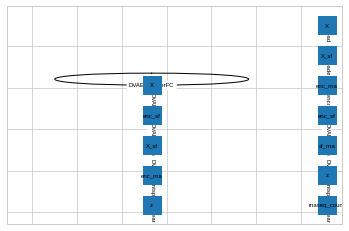

In [4]:
m.env.call_graph()

In [5]:
# Prepare all data
dataset = m.get_dataset()
all_data = dataset[range(0,adata.shape[0])]
all_data = {k: torch.from_numpy(v) for k, v in all_data.items()}

# Predict. TODO forward and use means for latent spaces

with torch.no_grad():
    loss_recorder = m.forward(all_data, do_sampling=False)
    predicted_exp = m.env.get_variable_as_tensor("rnaseq_count").detach().cpu().numpy()

In [6]:
loss_recorder._losses

{}

In [7]:
#adata = sc.read("data/small_rna.h5ad")

In [8]:
def pseudolog(x):
    return np.log(np.array(x)+1)

In [9]:
def todense(X):
    if hasattr(X,"todense"):
        return X.todense()
    else:
        return X

array([[1.       , 0.0179314],
       [0.0179314, 1.       ]])

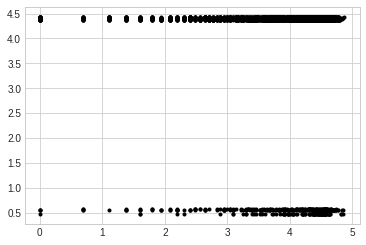

In [10]:
x = list(pseudolog(todense(adata.X[1:2000,]).flat))
y = list(pseudolog(predicted_exp[1:2000,].flat))
plt.plot(x, y, '.', color='black')
np.corrcoef(x,y)

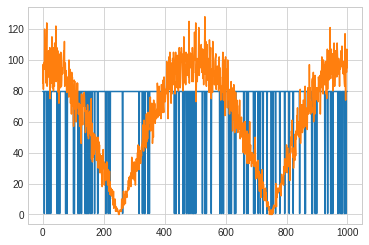

In [11]:
######## compare one gene vs prediction
x = list((todense(adata.X[:,1]).flat))
y = list((predicted_exp[:,1].flat))
#plt.plot(x, y, 'o', color='black')
#np.corrcoef(x,y)
plt.plot(y)
plt.plot(x)


array([[1.        , 0.00937439],
       [0.00937439, 1.        ]])

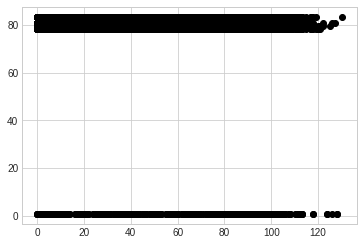

In [12]:
########### compare all genes
x = list((todense(adata.X[1:2000,]).flat))
y = list((predicted_exp[1:2000,].flat))
plt.plot(x, y, 'o', color='black')
np.corrcoef(x,y)

In [13]:
# sc.pl.umap(adata)
# https://github.com/YosefLab/scvi-tools/blob/master/scvi/train/_trainer.py


In [14]:
#z = zspace.get_latent_coordinates().detach().cpu().numpy()
z = m.env.get_variable_as_tensor("enc_rna")
print(z)
z = z.detach().cpu().numpy()

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.5413, 0.5413, 0.5413],
        [0.0000, 0.0000, 0.0000,  ..., 0.5413, 0.5413, 0.5413],
        [0.0000, 0.0000, 0.0000,  ..., 0.5413, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5413, 0.5413, 0.5413],
        [0.0000, 0.0000, 0.0000,  ..., 0.5413, 0.5413, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5413, 0.5413, 0.5413]])


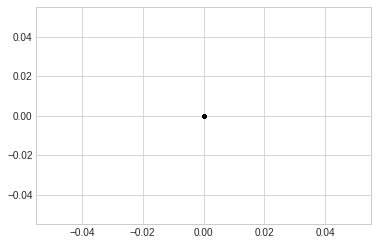

In [15]:
zx = z[:,0]
zy = z[:,1]
plt.plot(zx, zy, '.', color='black')

In [16]:
zx

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [17]:
#the_enc.layer
#the_dec.layer
#m
the_enc.layer.linear_layers[0].weight

Parameter containing:
tensor([[ 0.4316, -1.1124,  0.3670,  0.1080],
        [ 0.9057,  0.3599, -0.4818,  0.2128],
        [ 1.2330, -0.1118,  0.1500,  0.8765],
        [ 0.9429,  0.4970,  0.7956,  0.3842],
        [ 0.9596, -0.0787,  0.6293,  1.4816],
        [ 1.3138, -0.8716,  0.5073, -0.0241],
        [-0.8919,  0.8706,  0.1707,  0.2866],
        [ 0.0933,  0.4672, -1.7152,  0.2830],
        [-0.6923,  1.3815, -0.1449,  0.3788],
        [ 0.5443,  0.8824,  0.6619,  0.2286]], requires_grad=True)